# <font color = green>**BeHealthy Named Entity Recognition Assignment**<font>

##### <font color = green> By: Himanshu Srivastava <font>

# Identifying Entities in Healthcare Data

#### Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

In [40]:
#Import all required libraries

import spacy
import sklearn
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from collections import Counter
import pandas as pd

model = spacy.load("en_core_web_sm")

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

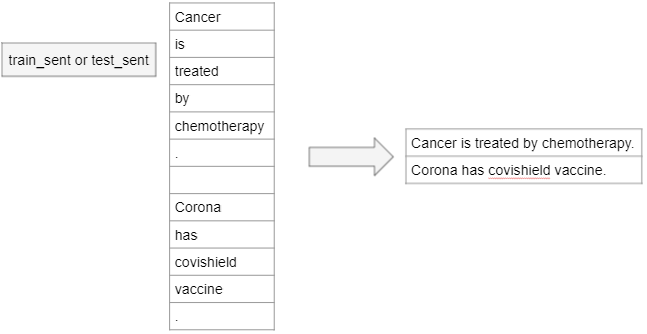

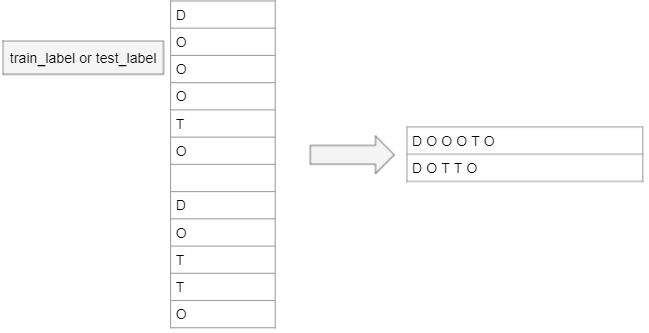

In [3]:
#Define a function that reads the file and splits the data when a blank line occurs ("\n\n"). 
#Replace every newline character in every element of list obtained with space to obtain a list of sentences/label sequences.

def data_preprocessing(sentenceFile):
    with open(sentenceFile, 'r') as sent_file:
        sent_list = sent_file.read().split("\n\n")
    sentences = [sentence.replace("\n", " ") for sentence in sent_list]
    return sentences

In [4]:
#Processing train and test dataset to recover the complete sentences and their labels.

train_sentences = data_preprocessing('train_sent')
train_labels = data_preprocessing('train_label')
test_sentences = data_preprocessing('test_sent')
test_labels = data_preprocessing('test_label')

## <font color="maroon">Task 1</font>

### Display five sentences along with their lables

In [5]:
#TRAIN

# Print the 5 sentence in the train set i.e. index value 5.
print(100*"=")
print("Displaying Five sentence from the train set")
print(100*"=")
print(train_sentences[:5])

# Print the labels of train sentence
print(train_labels[:5])

#TEST
print("\n\n")
print(100*"=")
print("Displaying Five sentence from the test set")
print(100*"=")
# Print the 6th sentence in the test set i.e. index value 5.
print(test_sentences[:5])

# Print the labels of test sentence
print(test_labels[:5])

Displaying Five sentence in the train set
['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )", "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]
['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O

### Count the number of sentences in the processed train and test dataset 

In [126]:
#Train Count
print("Number of sentences of train labels: ", len(train_sentences))

#Test Count
print("Number of sentences of test labels: ", len(test_sentences))

Number of sentences of train labels:  2600
Number of sentences of test labels:  1057


### Count the number of lines of labels in the processed train and test dataset.

In [125]:
#Train Label Count
print("Number of lines of train labels: ", len(train_labels))

#Test Label Count
print("Number of lines of test labels: ", len(test_labels))

Number of lines of train labels:  2600
Number of lines of test labels:  1057


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 


## <font color="maroon">Task 2</font>

### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [127]:
noun_propn_token = []
for combined_sent in (train_sentences + test_sentences):
    processed_doc = model(combined_sent.lower())
    for token in processed_doc:
        
        if token.pos_ in ["NOUN", "PROPN"]:
            noun_propn_token.append(token.text)
freq_df = Counter(noun_propn_token)   # Contains frequency of all words.

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [9]:
print(freq_df.most_common(25))

[('patients', 507), ('treatment', 304), ('%', 247), ('cancer', 211), ('therapy', 177), ('study', 172), ('disease', 150), ('cell', 142), ('lung', 118), ('results', 116), ('group', 111), ('effects', 99), ('gene', 91), ('chemotherapy', 91), ('use', 88), ('effect', 82), ('women', 81), ('analysis', 76), ('to_see', 75), ('risk', 74), ('surgery', 73), ('cases', 72), ('p', 72), ('rate', 68), ('dose', 68)]


## <font color="maroon">Task 3</font>

## Defining features for CRF





# Let's define the features to get the feature value for one word.

Following feature functions are used to compute the features of each word after converting the word to lower case

- f1  : the word itself
- f2  : POS_tag of the word
- f3  : last three characters of the word
- f4  : last two characters of the word
- f5  : length of the word
- f6  : the previous word
- f7  : POS_tag of the previous word
- f8  : length of the previous word
- f9  : if word is at the beginning of the sentence, add BEG
- f10 : if word is at the end of the sentence, add END

## Getting the features

In [10]:
# Function to get the feature value for one word.

def getFeaturesForOneWord(sentence, pos, tokens):
    word = sentence[pos].lower()
    word_pos_tag = tokens[pos].pos_
    features = ["word = " + word,                           # serves as word id
                "word_POS_tag = " + word_pos_tag,           # POS tag of a word
                "word[-3:] = " + word[-3:],                 # last three characters
                "word[-2:] = " + word[-2:],                 # last three characters
                "word_length = %s" % len(word)              # Length of the word
               ]

    if pos > 0:
        prev_word = sentence[pos-1]                                    
        prev_word_pos_tag = tokens[pos-1].pos_                         
        features.append("prev_word = " + prev_word)                    # serves as previous word id
        features.append("prev_word_POS_tag = " + prev_word_pos_tag)    # POS tag of previous word
        features.append("prev_word_length = %s" % len(prev_word))      # Length of previous word
    else:
        features.append("BEG")                              # feature to track begin of sentence 
  
    if pos == len(sentence) - 1:
        features.append("END")                              # feature to track end of sentence 
  
    return features

## <font color="maroon">Task 4</font>

### Write a code/function to get the features for a sentence

Define a function to get features for a sentence using the already defined **'getFeaturesForOneWord'** function

In [11]:
# Write a code to get features for a sentence.

def getFeaturesForOneSentence(sentence):
    sentence_list = sentence.split()
    tokens = model(sentence)
    getFeaturesForOneSentence = [getFeaturesForOneWord(sentence_list, pos, tokens) for pos in range(len(sentence_list))]
    return getFeaturesForOneSentence

### Write a code/function to get the labels of a sentence

In [12]:
# Write a code to get the labels for a sentence.

def getLabelsForOneSentence(labels):
    labels = labels.split()
    return labels

In [13]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences.

sample_sentence = train_sentences[5]
print(sample_sentence)

features = getFeaturesForOneSentence(sample_sentence)
features[5]

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age


['word = hospitals',
 'word_POS_tag = NOUN',
 'word[-3:] = als',
 'word[-2:] = ls',
 'word_length = 9',
 'prev_word = care',
 'prev_word_POS_tag = NOUN',
 'prev_word_length = 4']

## <font color="maroon">Task 5</font>

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

Get the features for sentences of X_train and X_test and get the labels of y_train and y_test data.

In [14]:
# Create a list of X_train and X_test for train and test sentences.

X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

### Define the labels as the target variable for test and the train dataset

In [15]:
# Create a list of y_train and y_test for train and test labels.

y_train = [getLabelsForOneSentence(labels) for labels in train_labels]
y_test = [getLabelsForOneSentence(labels) for labels in test_labels]

## <font color="maroon">Task 6</font>

## Build the CRF Model

We create a CRF object and pass training data to it. The model then "trains" and learns the weights for feature functions.

In [16]:
#To avoid AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

!pip install "scikit-learn<0.24"

In [17]:
print(sklearn.__version__)

0.23.2


In [22]:
# Build the CRF model.

model_crf = sklearn_crfsuite.CRF(max_iterations = 100)
model_crf.fit(X_train, y_train)

CRF(keep_tempfiles=None, max_iterations=100)

## <font color="maroon">Task 7</font>

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [28]:
y_pred = crf.predict(X_test)

In [29]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in test_sentences.

test_pred_sentence = test_sentences[5]
print(test_pred_sentence)

features = getFeaturesForOneSentence(test_pred_sentence)
features[5]

This study tested the hypothesis that to reduce the rate of macrosomic infants in gestational diabetes cases , good glycemic control should be initiated before 34 completed gestational weeks


['word = that',
 'word_POS_tag = PRON',
 'word[-3:] = hat',
 'word[-2:] = at',
 'word_length = 4',
 'prev_word = hypothesis',
 'prev_word_POS_tag = NOUN',
 'prev_word_length = 10']

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [30]:
metrics.flat_f1_score(y_test, y_pred, average = "weighted")

0.9239202770759253

## <font color="maroon">Task 8</font>

### Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

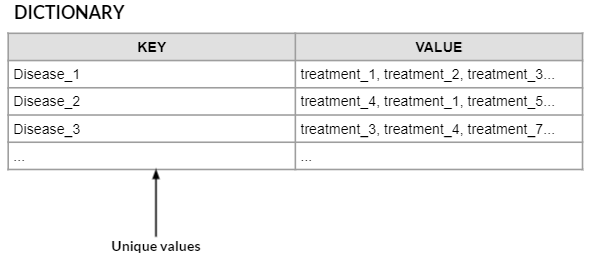

In [45]:
def disease_treament_identification(index):
    lbl_seq = y_pred[index]
    disease_index = []
    treatment_index = []
    
    for index, label in enumerate(lbl_seq):
        if label == "D":
            disease_index.append(index)
        
        if label == "T":
            treatment_index.append(index)
  
    return disease_index, treatment_index

In [64]:
for index, sentence in enumerate(test_sentences):
    print(index, sentence)
    disease_index, treatments_index = disease_treament_identification(index)
    print(disease_index, treatments_index)

0 Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
[] []
1 As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration
[] []
2 The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period
[] []
3 There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )
[] []
4 Fluctuations in ambient temperature are inversely correlated to changes in AFI
[] []
5 This study tested the hypothesis that to reduce the rate of macrosomic infants in gestational diabetes cases , good glycemic control should be initiated before 34 completed gestational weeks
[11, 12, 13, 14, 15, 16] [18, 19, 20]
6 In the `` early '' and ``

387 In this respect , the response of salivary amylase and salivary electrolytes to incremental levels of exercise is of particular interest
[] []
388 Tsa is the point during exercise at which the levels of salivary alpha-amylase and electrolytes ( especially Na+ ) also begin to rise above baseline levels
[] []
389 It has been determined that the plasma FFA turnover rate is sufficiently rapid to account for most of the fat metabolised during low intensity exercise ( 25 to 40 % VO2max )
[] []
390 However , an exercise intensity of 65 % VO2max results in a slight decrease in the amount of plasma FFA uptake by muscle tissue
[] []
391 Furthermore , it is widely documented that endurance activities increase the energy utilisation from fat while sparing carbohydrate sources
[] []
392 A clinical joint study on insulin therapy , a survey of the actual inter-laboratory differences in GHb measurement among 41 institutions and an assessment of 11 assay methods for the determination of GHb were pe

[] []
761 A specialist nurse can replace pre-registration house officers in the surgical pre-admission clinic
[] []
762 Ionized magnesium in serum and ultrafiltrate : pH and bicarbonate effect on measurements with the AVL 988-4 electrolyte analyzer
[] []
763 The Gram stain
[] []
764 When can odds ratios mislead ?
[] []
765 Enzyme structure with two catalytic sites for double-sieve selection of substrate
[] []
766 Role of the ketogenic diet in children with intractable seizures .
[8, 9] []
767 Evaluation of the microparticle enzyme immunoassay Abbott IMx Select Chlamydia and the importance of urethral site sampling to detect Chlamydia trachomatis in women
[19, 20] []
768 Secondary prevention for stroke after CAPRIE and ESPS-2
[3] []
769 < TO_SEE > New-onset angina preceding acute myocardial infarction is associated with improved contractile recovery after thrombolysis
[3, 4, 5, 6, 7, 8] []
770 Gorlin syndrome : identification of 4 novel germ-line mutations of the human patched ( PTCH ) 

1038 < TO_SEE > The effect of bisoprolol on perioperative mortality and myocardial infarction in high-risk patients undergoing vascular surgery
[8, 9, 10, 11, 12] []
1039 Surgical management of severe secondary peritonitis
[3, 4, 5] [0, 1]
1040 Treatment of hypertension with ascorbic acid
[2] []
1041 Efficacy of open-bite treatment with the Thera-spoon
[] []
1042 Hepatic arterial infusion of chemotherapy after resection of hepatic metastases from colorectal cancer
[8, 9, 10, 11, 12] [0, 1, 2, 3, 4, 6]
1043 Evidence for double resistance to permethrin and malathion in head lice
[9, 10] [5]
1044 Urgent colonoscopy for the diagnosis and treatment of severe diverticular hemorrhage
[8, 9, 10] []
1045 Effects of tolcapone , a catechol-O-methyltransferase inhibitor , on motor symptoms and pharmacokinetics of levodopa in patients with Parkinson 's disease .
[18, 19, 20] []
1046 Dry powdered formoterol , twice a day versus aerosolized salbutamol , four times a day , in patients with stable asth

In [115]:
# Display all diseases and its respective treatment in DataFrame for test sentences.

diseases = []
treatments = []

diseaseTreatmentRecords = pd.DataFrame(columns = ["Disease", "Treatment"])

for index, sentence in enumerate(test_sentences):
    sentence = sentence.split()
    disease_index, treatments_index = disease_treament_identification(index)
    
    if len(disease_index) > 0 and len(treatments_index) > 0:
        diseases.append(" ".join([sentence[i] for index, i in enumerate(disease_index) if index == 0 or i == disease_index[index]]))
        treatments.append(" ".join([sentence[i] for i in treatments_index]))

diseaseTreatmentRecords["Disease"] = diseases
diseaseTreatmentRecords["Treatment"] = treatments
diseaseTreatmentRecords

,Disease,Treatment
0,macrosomic infants in gestational diabetes cases,good glycemic control
1,cancer hereditary retinoblastoma,radiotherapy
2,epilepsy ADHD,Methylphenidate
3,unstable angina or non-Q-wave myocardial infar...,roxithromycin
4,coronary-artery disease,Antichlamydial antibiotics
...,...,...
165,head lice,permethrin
166,stable asthma,aerosolized salbutamol
167,Poliomyelitis,oral poliovirus vaccines
168,epithelial ovarian cancer,High-dose chemotherapy


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [116]:
diseaseTreatmentRecords[diseaseTreatmentRecords['Disease'].str.contains('hereditary retinoblastoma') == True]

,Disease,Treatment
1,cancer hereditary retinoblastoma,radiotherapy


Hence we can conclude or predict that for **"hereditary retinoblastoma"** disease recommended treament is **"radiotherapy"**

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# <font color = green>End of BeHealthy Named Entity Recognition Assignment</font>

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**